In [ ]:
# Mount "My Drive" into /content/drive
from google.colab import drive

google_drive_dir = "Final_project"  # @param
#bml-notebooks/
drive.mount('/content/drive')

mount_point = "/content/drive/My Drive/{}".format(google_drive_dir)

# Change the root directory to your mount_point
% cd '$mount_point'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Final_project


# <span style="color: royalblue;">Load Data</span>
Load the image data with labels.

In [ ]:
import numpy as np
from src.loadData import loadFer2013
from keras.utils import to_categorical


In [ ]:
X_train,X_val,X_test,y_train,y_val,y_test = loadFer2013('fer2013/icml_face_data.csv')

y_train_onehot = to_categorical(y_train)
y_val_onehot = to_categorical(y_val)
y_test_onehot = to_categorical(y_test)

/content/drive/My Drive/Final_project/src/loadData.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['emotion'][data['emotion']>1]-=1


In [ ]:
y_train_onehot.shape, y_val_onehot.shape, y_test_onehot.shape

((28709, 6), (3589, 6), (3589, 6))

In [ ]:
X_train.shape, y_train.shape

((28709, 48, 48), (28709,))

In [ ]:
emotions = {0: 'Angry', 1:'Fear', 2: 'Happy', 3: 'Sad', 4: 'Surprise', 5: 'Neutral'}

In [ ]:
class_names = list(emotions.values())
class_names

['Angry', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Extract features

In [ ]:
X_val.shape

(3589, 48, 48)

In [ ]:
X_data = np.vstack((X_train,X_val))
X_data.shape

(32298, 48, 48)

In [ ]:
X_data = X_data.reshape(32298,-1)
X_data.shape

(32298, 2304)

In [ ]:
X_test.shape

(3589, 48, 48)

In [ ]:
h,w = X_train[0].shape
h,w

(48, 48)

In [ ]:
import time
from sklearn.decomposition import PCA

n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_data.shape[0]))
t0 = time.time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_data)
print("done in %0.3fs" % (time.time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time.time()
X_train_pca = pca.transform(X_data)
X_test_pca = pca.transform(X_test.reshape(3589,-1))
print("done in %0.3fs" % (time.time() - t0))

Extracting the top 150 eigenfaces from 32298 faces
done in 16.931s
Projecting the input data on the eigenfaces orthonormal basis
done in 1.140s


# SVM Classification

In [ ]:

y_label = np.vstack((y_train_onehot,y_val_onehot))
y_label.shape

(32298, 6)

In [ ]:
from sklearn.svm import SVC
svm=SVC(kernel='rbf', class_weight='balanced',C=7)
st = time.time()
svm.fit(X_train_pca, y_label)
print(time.time()-st)
svm.score(X_train_pca, y_label)

#Evaluation

In [ ]:
# Quantitative evaluation of the model quality on the test set
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print("Predicting people's names on the test set")
t0 = time.time()
y_pred = svm.predict(X_test_pca)
print("done in %0.3fs" % (time.time() - t0))

print(classification_report(y_test, y_pred, target_names=class_names))
print(confusion_matrix(y_test, y_pred, labels=range(len(class_names))))

Predicting people's names on the test set
done in 30.392s
              precision    recall  f1-score   support

       Angry       0.31      0.33      0.32       467
        Fear       0.42      0.38      0.40       552
       Happy       0.60      0.67      0.64       895
         Sad       0.38      0.37      0.38       653
    Surprise       0.75      0.64      0.69       415
     Neutral       0.43      0.43      0.43       607

    accuracy                           0.48      3589
   macro avg       0.48      0.47      0.48      3589
weighted avg       0.48      0.48      0.48      3589

[[154  63  97  94   9  50]
 [ 83 212  72  80  38  67]
 [ 73  45 604  80  15  78]
 [ 93  84  96 241  16 123]
 [ 22  41  39  24 266  23]
 [ 66  61  97 112  13 258]]


In [ ]:
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.f1_score(y_test, y_pred,average='micro'))


0.4834215658957927
0.4834215658957927


In [ ]:
import matplotlib.pyplot as plt

def plot_gallery(images, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(images.shape[0]):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title('img'+str(i), size=12)
        plt.xticks(())
        plt.yticks(())

In [ ]:
eigenfaces.shape

(150, 48, 48)

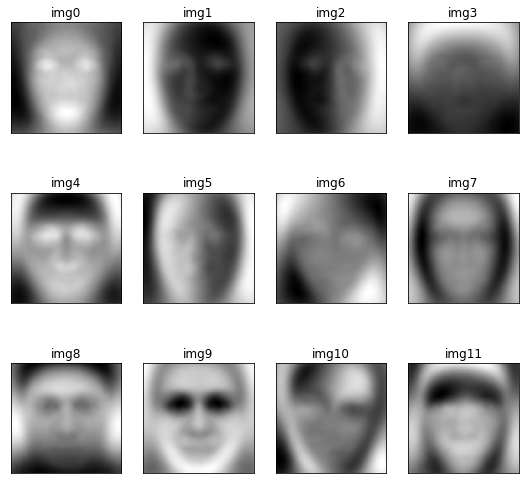

In [ ]:
plot_gallery(eigenfaces[:12],48,48)